In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# !pip install lifelines scikit-learn
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle, json, time, datetime, pymrmre, argparse, warnings

In [2]:
from lifelines import KaplanMeierFitter
import seaborn as sea

In [3]:
def save_obj_json(obj, name):
    with open(name, 'w') as fp:
        json.dump(obj, fp)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def normalize(train_set_, ignore = ['cohort', 'figo2018', 'event', 'time', 'shape_VoxelVolume']):

  for i, val in enumerate(list(train_set_)):
      if val not in ignore:
          me = train_set_[val].mean()
          stds = train_set_[val].std()
          train_set_[val] = (train_set_[val] - me)/stds
          # test_set_[val]  = (test_set_[val] - me)/stds

  return train_set_

In [17]:
def get_signatures(train_set_, train_set_target_, solution_length=3,
                   fixed=['cohort', 'figo2018'], solutions=100, data='both',
                   drop_cols = ['shape_VoxelVolume'], penalizer = False, id_=None):
    
    if id_ is None:
        raise Exception("Please add id's with train_set")
    else:
        assert len(train_set_) == len(id_)
      
    doc = {}
    avgci = 0.0
    
    print(f'Starting {solution_length}')
    if drop_cols is None:
        s = pymrmre.mrmr_ensemble(features=train_set_,
                          targets = train_set_target_.drop(columns=['time','figo2018']),
                          solution_length=solution_length, solution_count=solutions,
                          fixed_features=fixed)
    else:
        s = pymrmre.mrmr_ensemble(features=train_set_.drop(columns=drop_cols),
                                  targets = train_set_target_.drop(columns=['time','figo2018']),
                                  solution_length=solution_length, solution_count=solutions,
                                  fixed_features=fixed)

    feature_list = list(s.iloc[0])
    doc['feature_list'] = feature_list
    train_ci = []
    # coeficients used in enseble...
    coefs = []
    train_mrmr = train_set_.copy()
    train_mrmr['event'] = train_set_target_['event']
    train_mrmr['time'] = train_set_target_['time']
    # set_features = ['cohort','shape_VoxelVolume', 'figo2018']
    exclude = ['cohort', 'time', 'event','shape_VoxelVolume', 'figo2018']
    cis = []
    
    for z, set_ in enumerate(feature_list):

        # fit cox model with chosen features
        cph1 = CoxPHFitter(penalizer=penalizer) #penalizer=0.01
        cph1.fit(train_mrmr[set_ + ['time', 'event']], duration_col='time', event_col='event', show_progress=False) # step_size=0.25
        coef = cph1.params_
        ci = cph1.concordance_index_
        cis.append(ci)
        coefs.append(coef)

        for c, val in enumerate(set_):

          if val not in exclude:
              v =  train_mrmr[val]*coef[val]
              # v_test =  test_mrmr[val]*coef[val]
              # calculates signature from all the features ...
              try:
                  train_mrmr['Signature'] += v
                  # test_mrmr['Signature0'] += v_test
              except Exception:
                  train_mrmr['Signature'] = v
                  # test_mrmr['Signature0'] = v_test

        if z%10 == 0:
            print(f'Done solution {z} for {solution_length} features.')
    
    doc['coefs'] = coefs
    doc['train_cis'] = cis
    try:
        chosen = ['event','time', 'cohort', 'shape_VoxelVolume', 'figo2018', 'Signature']
        b = train_mrmr[chosen]
    except Exception:
        chosen = ['event','time', 'cohort', 'figo2018', 'Signature']
        b = train_mrmr[chosen]
    # btest = test_mrmr[chosen0]
    b['Signature'] /= len(feature_list)
    
    ##################################
    # fit final model for ensemble...
    cphf =  CoxPHFitter() # penalizer=0.01
    cphf.fit(b, duration_col='time', event_col='event', show_progress=False) # step_size=0.1
    # calculate train concordance
    c1 = cphf.concordance_index_
    train_ci.append(c1)

    # use signature to calculate test concordance...
#     test_signature = -cphf.predict_partial_hazard(btest).values
#     c2 = concordance_index(btest['time'], test_signature, btest['event'])
#     test_ci.append(c2)

    doc['train_ci'] = c1
    b["ID"] = id_
    doc['data'] = b
    print(f'Done building signature for {solutions} solutions. Average Train CI == {c1}')
    return doc

In [5]:
# import data
select = pd.read_csv('/Users/joemarsilla/Documents/Cervix/Data/Features_with_all_ICC_above_0.5.csv')
combined_feat = pd.read_csv('/Users/joemarsilla/Documents/Cervix/Combinied_data_for_Joe_2020_06_16.csv')
edited = combined_feat.drop(columns=['ID','figo']) # 'shape_VoxelVolume', 'figo', 'ID'
cohort_norm=False
stage=False

In [6]:
combined_feat.head()

,ID,time,event,figo,figo2018,cohort,firstorder_InterquartileRange,firstorder_Uniformity,firstorder_Median,firstorder_Energy,...,wavelet.wavelet.LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet.wavelet.LLL_glszm_SizeZoneNonUniformityNormalized,wavelet.wavelet.LLL_glszm_SizeZoneNonUniformity,wavelet.wavelet.LLL_glszm_GrayLevelNonUniformity,wavelet.wavelet.LLL_glszm_ZonePercentage,wavelet.wavelet.LLL_glszm_SmallAreaEmphasis,wavelet.wavelet.LLL_ngtdm_Coarseness,wavelet.wavelet.LLL_ngtdm_Complexity,wavelet.wavelet.LLL_ngtdm_Contrast,wavelet.wavelet.LLL_ngtdm_Busyness
0,ANON03R4FB1LJ,3.263518,1,2B,3C1,Neitherlands,0.262374,0.069203,0.487589,7533.119468,...,0.000455,0.456227,4957.361495,270.953065,0.502776,0.702357,0.000451,42620.534660,0.070691,0.268941
1,ANON0T8FGB1B1,3.203285,0,2B,2B,Neitherlands,0.742252,0.025575,1.314625,36374.179830,...,0.000178,0.644915,9041.058492,152.399672,0.759097,0.830781,0.000569,142105.951600,0.390273,0.080585
2,ANON163OEB1LK,4.777550,0,2A,2A,Neitherlands,0.210350,0.087404,0.087533,39.470400,...,0.002433,0.474761,270.138840,23.699473,0.585391,0.716488,0.007814,3548.034126,0.165249,0.076263
3,ANON1LJCRC12N,3.214237,0,1B1,2B,Neitherlands,0.261070,0.070616,0.165399,72.337592,...,0.002734,0.543428,272.257485,14.305389,0.641485,0.765654,0.009914,6775.997656,0.305103,0.064047
4,ANON1LT4GB140,3.019849,0,3B,3C1,Neitherlands,0.144166,0.126477,0.081973,1405.914778,...,0.000270,0.308334,3577.906756,440.124612,0.182933,0.572225,0.000200,5360.470413,0.018768,1.428442


In [7]:
a = list(edited['figo2018'])

In [8]:
a

['3C1',
 '2B',
 '2A',
 '2B',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '2B',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '2B',
 '3C1',
 '2B',
 '2B',
 '3C1',
 '3C1',
 '3C1',
 '1B',
 '3B',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '4A',
 '3C2',
 '2B',
 '2B',
 '2B',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '2B',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '3C1',
 '2A',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '2B',
 '3C1',
 '3C2',
 '3C1',
 '3C2',
 '3C1',
 '1B',
 '2B',
 '3C2',
 '3C1',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '3C2',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C1',
 '3C',
 '3B',
 '1B1',
 '3C',
 '3C',
 '2B',
 '1B1',
 '4A',
 '2B',
 '1B1',
 '3C',
 '3C',
 '2B',
 '3C',
 '3C',
 '4A',
 '3C',
 '1B1',
 '2B',
 '2B',
 '2B',
 '3C',
 '3A',
 '3C',
 '3C',
 '3A',
 '4A',
 '2B',
 '2B',
 '3B',
 '2B',
 '3C',
 '3C',
 '2B',
 '4A',
 '3C',
 '4A',
 '3C',
 '3C

In [9]:
# assign staging
values = {'1B':0, '1B1':0, '2A':0, '2B':0, '3A':1, '3B':1, '3C':1, '3C1':1, '3C2':1, '4A':1, '4B':1}
a = list(edited['figo2018'])
a = [aa for aa in a]
print(a, len(a))
b = []

for val in a:
    b.append(values[val])

edited['figo2018'] = b
# idify cohort to normalize by it...
vals = {'Neitherlands':0, 'TCGA':1}
a = list(edited ['cohort'])
print(a)
b = []

for val in a:
    b.append(vals[val])

edited['cohort'] = b
edited = edited.astype('double')
# d = args.choose_data
# if d != 'both':
#     # only choose Netherlands
#     warnings.warn('Using Norway Data ONLY')
#     edited = edited[edited['cohort'] == 0]

['3C1', '2B', '2A', '2B', '3C1', '3C2', '3C1', '3C1', '3C1', '3C2', '3C1', '3C1', '3C2', '3C1', '2B', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '2B', '3C1', '2B', '2B', '3C1', '3C1', '3C1', '1B', '3B', '3C1', '3C1', '3C2', '3C1', '3C1', '4A', '3C2', '2B', '2B', '2B', '3C1', '3C1', '3C1', '3C1', '3C1', '2B', '3C1', '3C1', '3C2', '3C1', '3C1', '3C1', '2A', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '2B', '3C1', '3C2', '3C1', '3C2', '3C1', '1B', '2B', '3C2', '3C1', '3C1', '3C1', '3C2', '3C1', '3C1', '3C2', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C1', '3C', '3B', '1B1', '3C', '3C', '2B', '1B1', '4A', '2B', '1B1', '3C', '3C', '2B', '3C', '3C', '4A', '3C', '1B1', '2B', '2B', '2B', '3C', '3A', '3C', '3C', '3A', '4A', '2B', '2B', '3B', '2B', '3C', '3C', '2B', '4A', '3C', '4A', '3C', '3C'] 132
['Neitherlands', 'Neitherlands', 'Neitherlands', 'Neitherlands', 'Neitherlands', 'Neitherlands', 'Neitherlands', 'Neitherlan

In [10]:
edited["ID"]=combined_feat["ID"]

In [13]:
id_ = list(edited["ID"])

In [11]:
train_set, train_set_target = edited.drop(columns=['event','time', "ID"], axis=1), edited[['event','time','figo2018']]
train_set.to_csv('use_for_normalization.csv')
train_set = normalize(train_set)
a = list(train_set)
# run to drop shape features...
for lab in a:
    if 'shape' in str(lab):
        if 'VoxelVolume' not in str(lab):
            train_set=train_set.drop(columns=[str(lab)])
            print(f"{lab} 'Dropped'.")

shape_Maximum3DDiameter 'Dropped'.
shape_MajorAxisLength 'Dropped'.
shape_Sphericity 'Dropped'.
shape_LeastAxisLength 'Dropped'.
shape_Elongation 'Dropped'.
shape_SurfaceVolumeRatio 'Dropped'.
shape_Maximum2DDiameterSlice 'Dropped'.
shape_Flatness 'Dropped'.
shape_SurfaceArea 'Dropped'.
shape_MinorAxisLength 'Dropped'.
shape_Maximum2DDiameterColumn 'Dropped'.
shape_Maximum2DDiameterRow 'Dropped'.


In [9]:
train_set['cohort'].sum()

39.0

In [10]:
train_set['shape_VoxelVolume']

0       31121.28
1       26593.92
2        1399.68
3        1124.64
4       91343.52
         ...    
127    172563.84
128    161465.76
129    268732.80
130     18129.60
131     92016.00
Name: shape_VoxelVolume, Length: 132, dtype: float64

In [13]:
# this is for stage ONLY, no VOLUME...
doc = get_signatures(train_set, train_set_target, solution_length=2,
                     drop_cols=['shape_VoxelVolume', 'figo2018'],
                     fixed=['cohort'], solutions=100)

Starting 2
Done solution 0 for 2 features.
Done solution 10 for 2 features.
Done solution 20 for 2 features.
Done solution 30 for 2 features.
Done solution 40 for 2 features.
Done solution 50 for 2 features.
Done solution 60 for 2 features.
Done solution 70 for 2 features.
Done solution 80 for 2 features.
Done solution 90 for 2 features.
Done building signature for 100 solutions. Average Train CI == 0.7174971031286211


/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_40302/1155564082.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [14]:
coef_100 = pd.DataFrame(doc['coefs'])
coef_100.to_csv('radiomicsx1_volume_100_UPDATED.csv')

In [15]:
coef_100.head()

covariate,cohort,log.sigma.4.5.mm.3D_glcm_Correlation,wavelet.wavelet.LHH_ngtdm_Coarseness,log.sigma.4.5.mm.3D_ngtdm_Coarseness,log.sigma.2.5.mm.3D_firstorder_Minimum,log.sigma.1.5.mm.3D_gldm_DependenceNonUniformity,log.sigma.5.0.mm.3D_glcm_Idn,log.sigma.2.0.mm.3D_glrlm_RunLengthNonUniformity,log.sigma.4.0.mm.3D_glcm_Idn,log.sigma.3.5.mm.3D_ngtdm_Coarseness,...,wavelet.wavelet.LLL_glszm_GrayLevelNonUniformity,wavelet.wavelet.LLH_glszm_GrayLevelNonUniformity,wavelet.wavelet.LLL_glcm_Idmn,log.sigma.0.5.mm.3D_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLH_gldm_DependenceNonUniformity,wavelet.wavelet.HLL_glrlm_RunLengthNonUniformity,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity,wavelet.wavelet.HHH_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet.wavelet.LLH_glcm_Imc2,wavelet.wavelet.LLL_glcm_Correlation
coef,1.032661,0.616554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.583658,NaN,-2.031927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.598161,NaN,NaN,-1.430302,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.812060,NaN,NaN,NaN,-0.347803,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.707932,NaN,NaN,NaN,NaN,0.184309,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
doc['data'].to_csv('info_radiomicsx1_volume_100_UPDATED.csv')

In [23]:
cis = np.array(doc['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.687 (0.654 - 0.717)


In [24]:
med = doc['data']['Signature'].median()

In [38]:
# plot for > -0.00751
med = doc['data']['Signature'].median()
data_ = doc['data']
d_high = data_[data_['Signature']>0]
d_low = data_[data_['Signature']<=0]
d_high.head()

,event,time,cohort,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,0.0,31121.28,1.0,0.257722
4,0.0,3.019849,0.0,91343.52,1.0,0.375048
5,0.0,4.147844,0.0,37571.04,1.0,0.208935
6,1.0,1.048597,0.0,69436.80,1.0,0.358778
7,0.0,3.200548,0.0,15701.76,1.0,0.043051


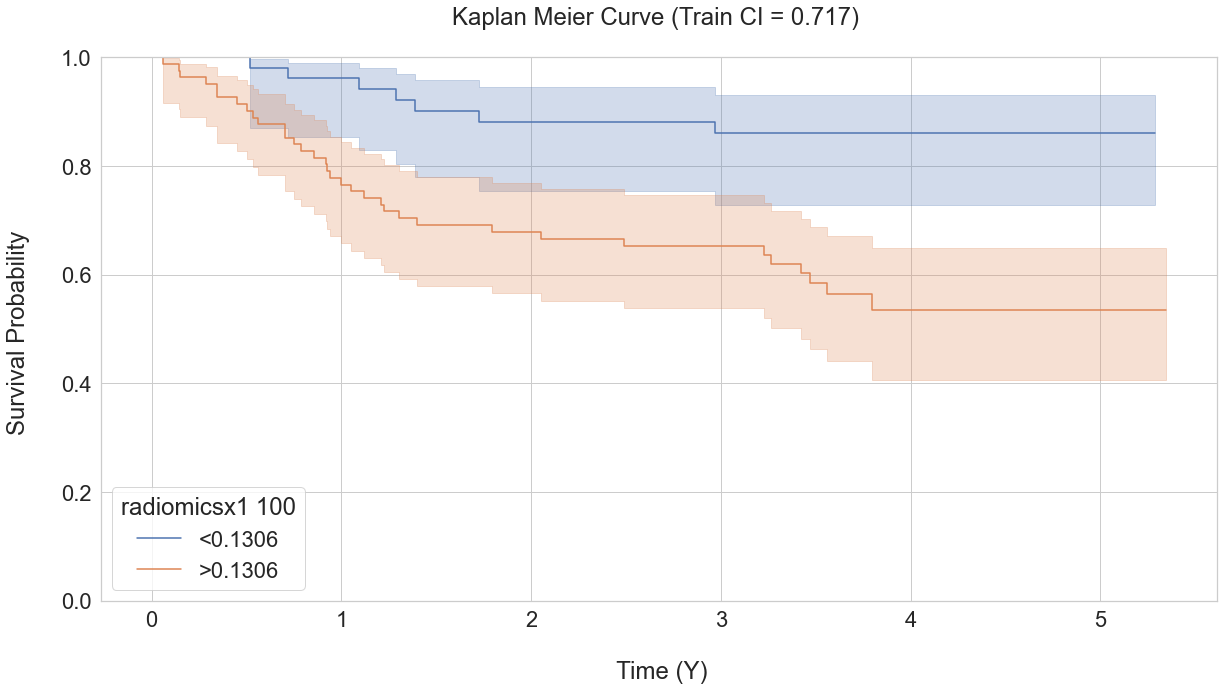

In [39]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(doc['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 100')


In [40]:
data_.to_csv('radiomics_shape_volume_100.csv')

In [75]:
#### this is for stage ONLY, no VOLUME...
doc = get_signatures(train_set, train_set_target, solution_length=4, drop_cols=None,
                     fixed=['cohort', 'figo2018', 'shape_VoxelVolume'], solutions=500)

Starting 4
Done solution 0 for 4 features.
Done solution 10 for 4 features.
Done solution 20 for 4 features.
Done solution 30 for 4 features.
Done solution 40 for 4 features.
Done solution 50 for 4 features.
Done solution 60 for 4 features.
Done solution 70 for 4 features.
Done solution 80 for 4 features.
Done solution 90 for 4 features.
Done solution 100 for 4 features.
Done solution 110 for 4 features.
Done solution 120 for 4 features.
Done solution 130 for 4 features.
Done solution 140 for 4 features.
Done solution 150 for 4 features.
Done solution 160 for 4 features.
Done solution 170 for 4 features.
Done solution 180 for 4 features.
Done solution 190 for 4 features.
Done solution 200 for 4 features.
Done solution 210 for 4 features.
Done solution 220 for 4 features.
Done solution 230 for 4 features.
Done solution 240 for 4 features.
Done solution 250 for 4 features.
Done solution 260 for 4 features.
Done solution 270 for 4 features.
Done solution 280 for 4 features.
Done solution 

<ipython-input-40-3c73fc4bbdc1>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [76]:
coef_500_svr = pd.DataFrame(doc['coefs'])
coef_500_svr.to_csv('stage_radiomicsx1_volume_500.csv')

In [77]:
cis = np.array(doc['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')
med = doc['data']['Signature'].median()
# plot for > -0.00751
med = doc['data']['Signature'].median()
data_ = doc['data']
d_high = data_[data_['Signature']>med]
d_low = data_[data_['Signature']<med]
d_high.head()

0.689 (0.656 - 0.732)


,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.093613
1,0.0,3.203285,26593.92,0.0,0.114674
5,0.0,4.147844,37571.04,1.0,0.059384
6,1.0,1.048597,69436.80,1.0,0.107392
8,0.0,4.276523,69471.36,1.0,0.078279


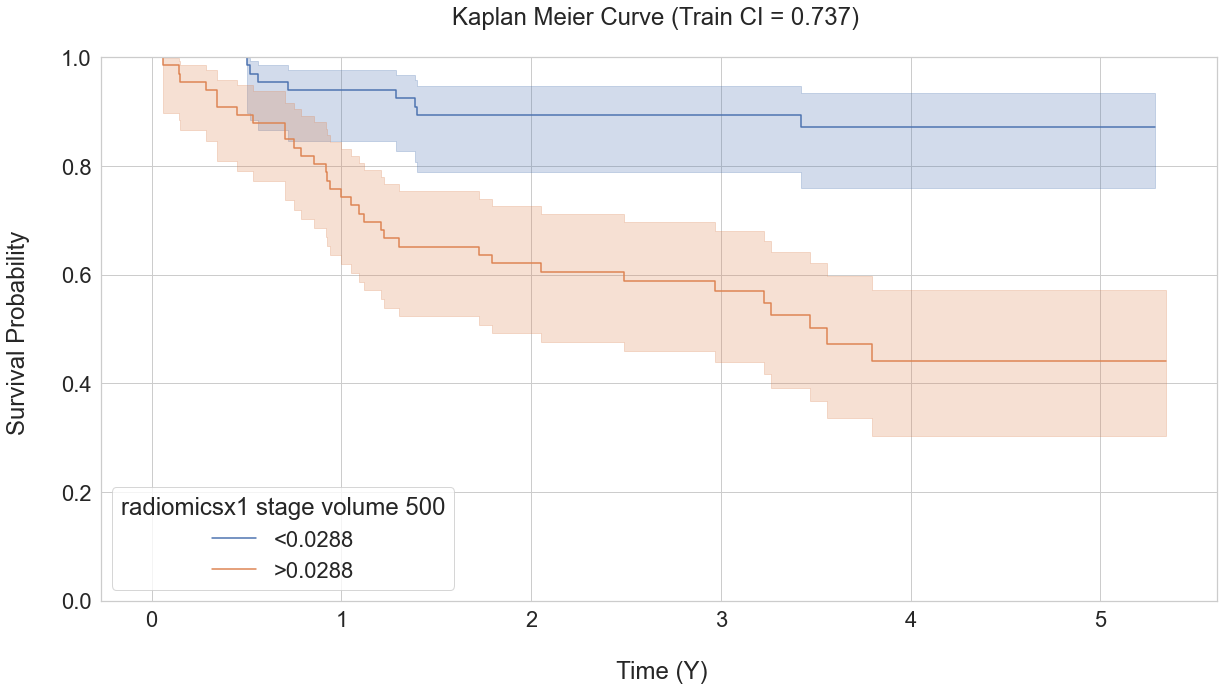

In [78]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(doc['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 stage volume 500')

In [79]:
data_.to_csv('radiomics_stage_volume_500.csv')

In [80]:
# this is for stage ONLY, no VOLUME...
doc = get_signatures(train_set, train_set_target, solution_length=3,
                     fixed=['cohort'],  drop_cols=['shape_VoxelVolume', 'figo2018'], solutions=100)

Starting 3
Done solution 0 for 3 features.
Done solution 10 for 3 features.
Done solution 20 for 3 features.
Done solution 30 for 3 features.
Done solution 40 for 3 features.
Done solution 50 for 3 features.
Done solution 60 for 3 features.
Done solution 70 for 3 features.
Done solution 80 for 3 features.
Done solution 90 for 3 features.
Done building signature for 100 solutions. Average Train CI == 0.7005793742757822


<ipython-input-40-3c73fc4bbdc1>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [81]:
cis = np.array(doc['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.688 (0.668 - 0.722)


In [82]:
med = doc['data']['Signature'].median()

In [83]:
# plot for > -0.00751
med = doc['data']['Signature'].median()
data_ = doc['data']
d_high = data_[data_['Signature']>med]
d_low = data_[data_['Signature']<med]
d_high.head()

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.061467
1,0.0,3.203285,26593.92,0.0,0.050066
4,0.0,3.019849,91343.52,1.0,0.021842
5,0.0,4.147844,37571.04,1.0,0.001863
6,1.0,1.048597,69436.80,1.0,0.134807


In [84]:
kmf = KaplanMeierFitter()

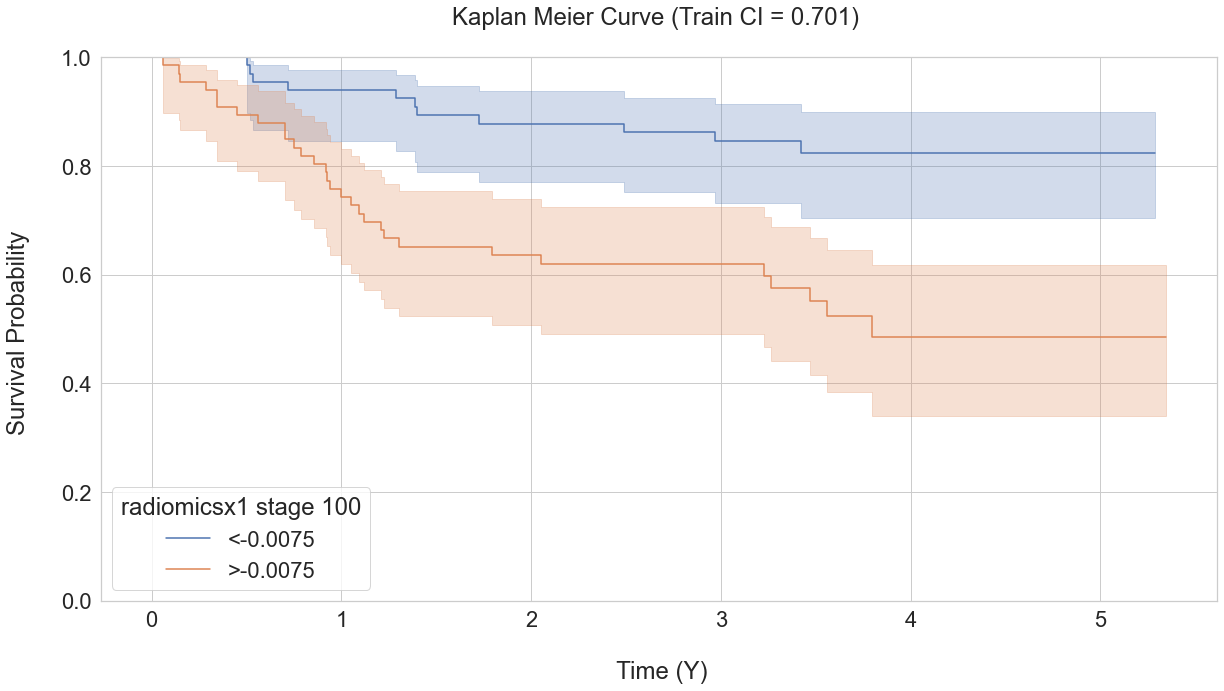

In [85]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(doc['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 stage 100')


In [86]:
data_.to_csv('radiomics_stage_100.csv')

In [87]:
coef_100 = pd.DataFrame(doc['coefs'])
coef_100.to_csv('stage_radiomicsx1_100.csv')

In [88]:
coef_100

covariate,cohort,figo2018,log.sigma.3.0.mm.3D_glszm_LargeAreaHighGrayLevelEmphasis,log.sigma.3.5.mm.3D_glszm_ZoneEntropy,wavelet.wavelet.HHH_gldm_DependenceNonUniformity,log.sigma.3.5.mm.3D_gldm_GrayLevelNonUniformity,log.sigma.4.0.mm.3D_glszm_LargeAreaHighGrayLevelEmphasis,gldm_GrayLevelNonUniformity,log.sigma.2.5.mm.3D_gldm_SmallDependenceLowGrayLevelEmphasis,firstorder_Range,...,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity,wavelet.wavelet.HLH_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLH_glszm_GrayLevelNonUniformity,log.sigma.1.5.mm.3D_glszm_GrayLevelNonUniformity,log.sigma.1.0.mm.3D_glrlm_RunLengthNonUniformity,log.sigma.0.5.mm.3D_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLH_gldm_DependenceNonUniformity,wavelet.wavelet.HLL_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLH_glcm_Imc2,wavelet.wavelet.LLL_glcm_Correlation
coef,1.102623,1.228290,0.061364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.452262,0.967974,NaN,0.777148,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,0.948237,1.108662,NaN,NaN,0.162823,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.063741,1.184170,NaN,NaN,NaN,0.094307,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.106746,1.233094,NaN,NaN,NaN,NaN,0.058201,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
coef,1.061199,1.180078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.114935,NaN,NaN,NaN,NaN
coef,1.053745,1.175892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.115976,NaN,NaN,NaN
coef,1.043337,1.171350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127423,NaN,NaN
coef,0.668130,0.865473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.606375,NaN


In [54]:
# doc['coefs']

In [89]:
doc['train_ci']

0.7005793742757822

In [90]:
doc_500 = get_signatures(train_set, train_set_target, solution_length=3,
                     fixed=['cohort', 'figo2018'], drop_cols=['shape_VoxelVolume'], solutions=500)

Starting 3
Done solution 0 for 3 features.
Done solution 10 for 3 features.
Done solution 20 for 3 features.
Done solution 30 for 3 features.
Done solution 40 for 3 features.
Done solution 50 for 3 features.
Done solution 60 for 3 features.
Done solution 70 for 3 features.
Done solution 80 for 3 features.
Done solution 90 for 3 features.
Done solution 100 for 3 features.
Done solution 110 for 3 features.
Done solution 120 for 3 features.
Done solution 130 for 3 features.
Done solution 140 for 3 features.
Done solution 150 for 3 features.
Done solution 160 for 3 features.
Done solution 170 for 3 features.
Done solution 180 for 3 features.
Done solution 190 for 3 features.
Done solution 200 for 3 features.
Done solution 210 for 3 features.
Done solution 220 for 3 features.
Done solution 230 for 3 features.
Done solution 240 for 3 features.
Done solution 250 for 3 features.
Done solution 260 for 3 features.
Done solution 270 for 3 features.
Done solution 280 for 3 features.
Done solution 

<ipython-input-40-3c73fc4bbdc1>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [91]:
cis = np.array(doc_500['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.675 (0.597 - 0.723)


In [92]:
med = doc_500['data']['Signature'].median()
data_5 = doc_500['data']
d_high_500 = data_5[data_5['Signature']>med]
d_low_500 = data_5[data_5['Signature']<med]
d_high_500.head()

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.083907
1,0.0,3.203285,26593.92,0.0,0.062327
4,0.0,3.019849,91343.52,1.0,0.061586
5,0.0,4.147844,37571.04,1.0,0.056744
6,1.0,1.048597,69436.80,1.0,0.125942


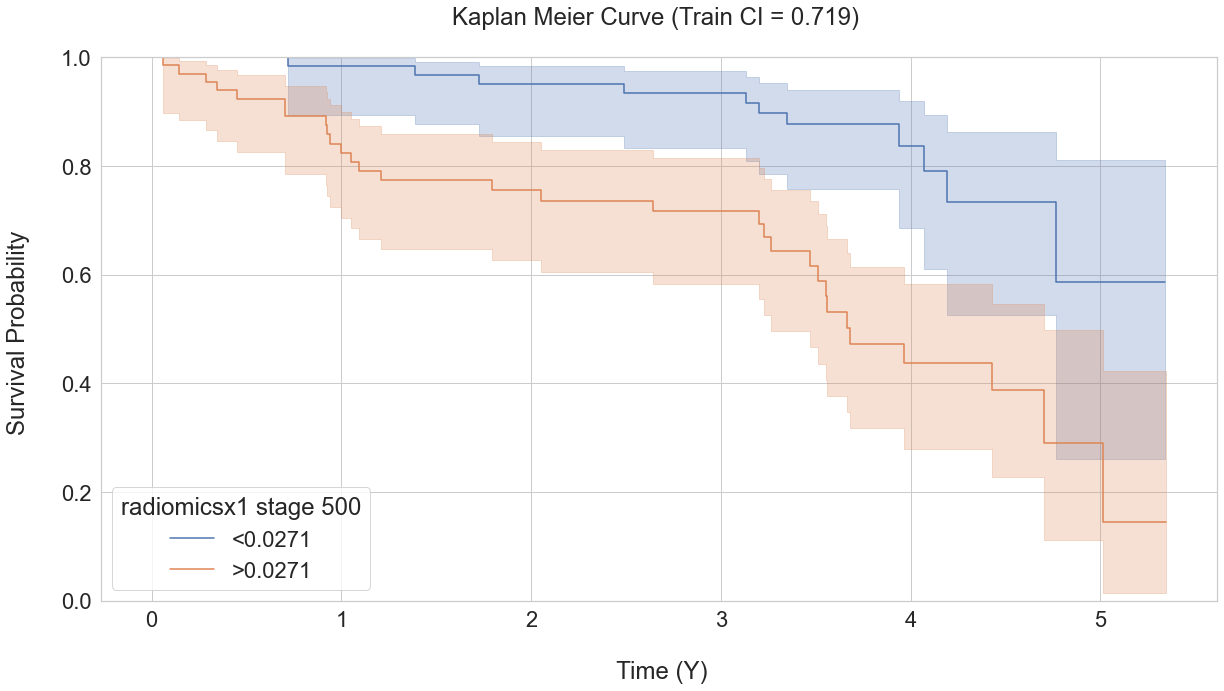

In [93]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low_500['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high_500['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(doc_500['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 stage 500')

In [94]:
data_5.to_csv('radiomics_stage_500.csv')

In [95]:
coef_500 = pd.DataFrame(doc_500['coefs'])

In [96]:
coef_500.to_csv('stage_radiomicsx1_500.csv')

In [97]:
doc_500['train_ci']

0.719351100811124

In [98]:
# this is for RADIOMICS only 
docrad = get_signatures(train_set, train_set_target, solution_length=2,
                        drop_cols = ['figo2018', 'shape_VoxelVolume'], fixed=['cohort'],
                        solutions=100)

Starting 2
Done solution 0 for 2 features.
Done solution 10 for 2 features.
Done solution 20 for 2 features.
Done solution 30 for 2 features.
Done solution 40 for 2 features.
Done solution 50 for 2 features.
Done solution 60 for 2 features.
Done solution 70 for 2 features.
Done solution 80 for 2 features.
Done solution 90 for 2 features.
Done building signature for 100 solutions. Average Train CI == 0.6831981460023175


<ipython-input-40-3c73fc4bbdc1>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [99]:
cis = np.array(docrad['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.687 (0.654 - 0.717)


In [100]:
med = docrad['data']['Signature'].median()
datarad = docrad['data']
d_high_r = datarad[datarad['Signature']>med]
d_low_r = datarad[datarad['Signature']<med]
d_high_r.head()

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.257722
4,0.0,3.019849,91343.52,1.0,0.375048
5,0.0,4.147844,37571.04,1.0,0.208935
6,1.0,1.048597,69436.80,1.0,0.358778
8,0.0,4.276523,69471.36,1.0,0.381301


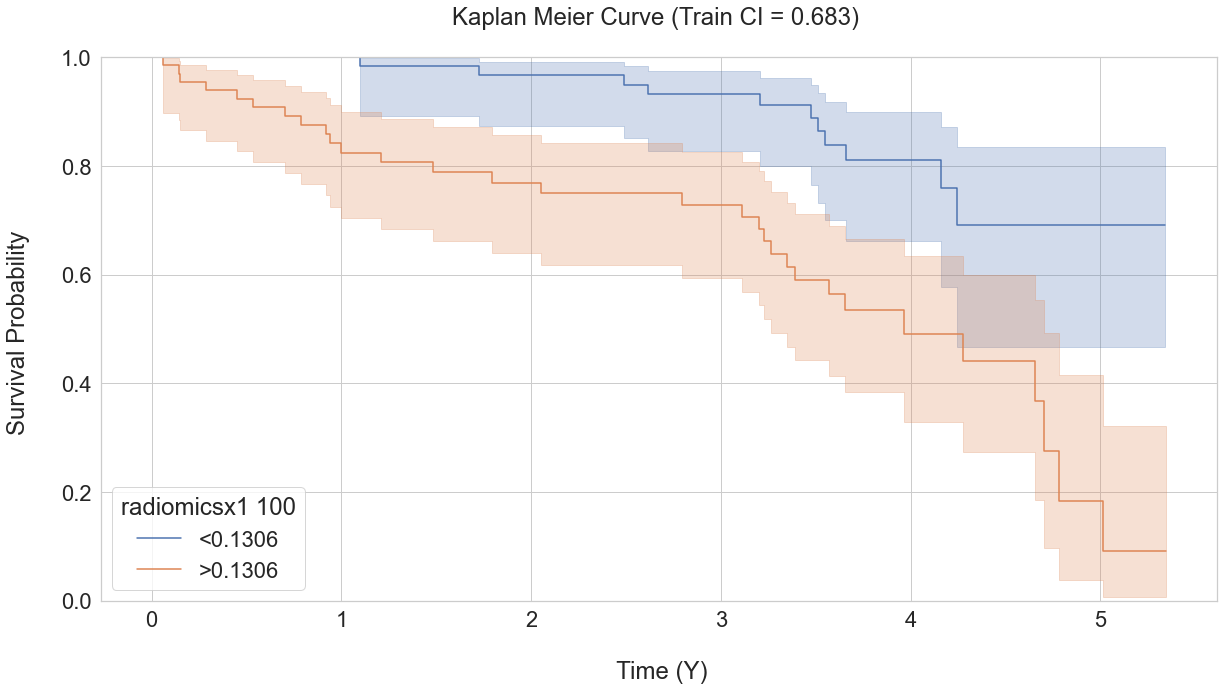

In [101]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low_r['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high_r['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(docrad['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 100')

In [102]:
datarad.to_csv('radiomics_100_signature.csv')

In [103]:
docrad['data']

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.257722
1,0.0,3.203285,26593.92,0.0,-0.004269
2,0.0,4.777550,1399.68,0.0,-1.942575
3,0.0,3.214237,1124.64,0.0,-2.268070
4,0.0,3.019849,91343.52,1.0,0.375048
...,...,...,...,...,...
127,1.0,0.284736,172563.84,1.0,0.475236
128,1.0,0.939083,161465.76,1.0,0.425621
129,1.0,0.057495,268732.80,1.0,0.603047
130,1.0,1.092402,18129.60,1.0,-0.006635


In [104]:
docrad['train_ci']

0.6831981460023175

In [105]:
coef_100 = pd.DataFrame(docrad['coefs'])
coef_100.to_csv('radiomicsx1_only_100.csv')

In [106]:
# this is for RADIOMICS only 
docrad_500 = get_signatures(train_set, train_set_target, solution_length=2,
                        drop_cols = ['figo2018', 'shape_VoxelVolume'], fixed=['cohort'],
                        solutions=500)

Starting 2
Done solution 0 for 2 features.
Done solution 10 for 2 features.
Done solution 20 for 2 features.
Done solution 30 for 2 features.
Done solution 40 for 2 features.
Done solution 50 for 2 features.
Done solution 60 for 2 features.
Done solution 70 for 2 features.
Done solution 80 for 2 features.
Done solution 90 for 2 features.
Done solution 100 for 2 features.
Done solution 110 for 2 features.
Done solution 120 for 2 features.
Done solution 130 for 2 features.
Done solution 140 for 2 features.
Done solution 150 for 2 features.
Done solution 160 for 2 features.
Done solution 170 for 2 features.
Done solution 180 for 2 features.
Done solution 190 for 2 features.
Done solution 200 for 2 features.
Done solution 210 for 2 features.
Done solution 220 for 2 features.
Done solution 230 for 2 features.
Done solution 240 for 2 features.
Done solution 250 for 2 features.
Done solution 260 for 2 features.
Done solution 270 for 2 features.
Done solution 280 for 2 features.
Done solution 

<ipython-input-40-3c73fc4bbdc1>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)


In [107]:
cis = np.array(docrad_500['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.658 (0.507 - 0.717)


In [108]:
med = docrad_500['data']['Signature'].median()
datarad5 = docrad_500['data']
d_high_r5 = datarad5[datarad5['Signature']>med]
d_low_r5 = datarad5[datarad5['Signature']<med]
d_high_r.head()

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.257722
4,0.0,3.019849,91343.52,1.0,0.375048
5,0.0,4.147844,37571.04,1.0,0.208935
6,1.0,1.048597,69436.80,1.0,0.358778
8,0.0,4.276523,69471.36,1.0,0.381301


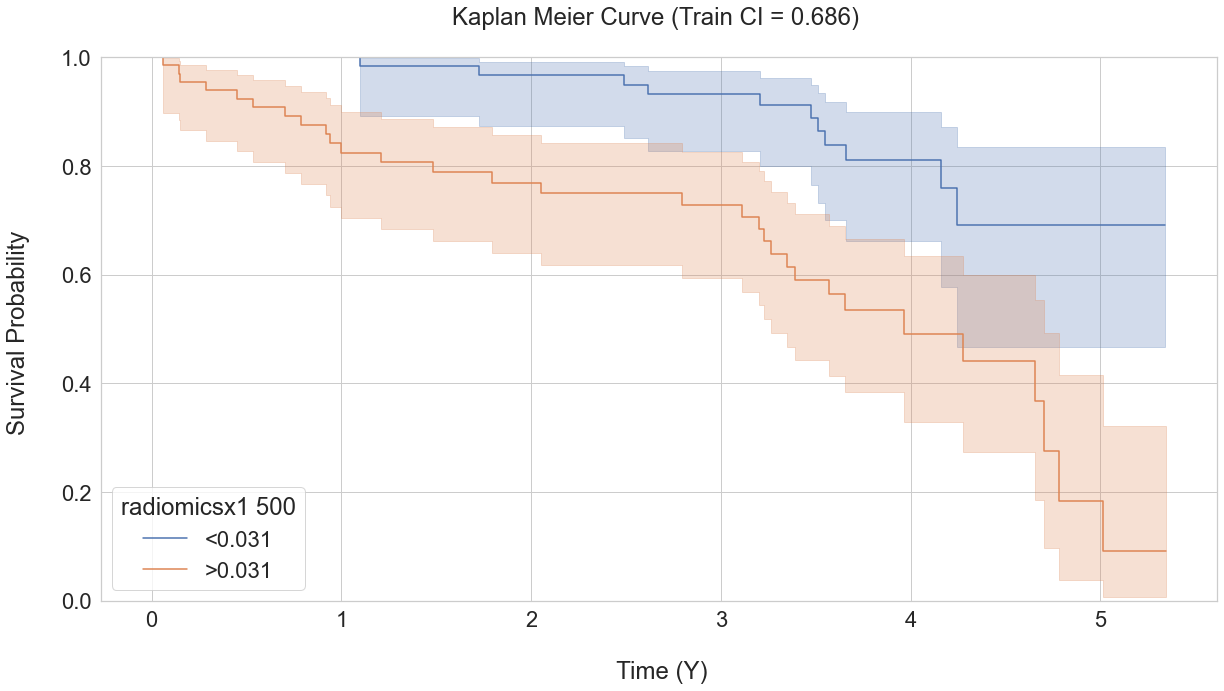

In [109]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low_r5['time'], event_observed=d_low['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high_r5['time'], event_observed=d_high['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(docrad_500['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx1 500')

In [110]:
datarad5.to_csv('radiomics_500_signature.csv')

In [111]:
docrad_500['data']

,event,time,shape_VoxelVolume,figo2018,Signature
0,1.0,3.263518,31121.28,1.0,0.091394
1,0.0,3.203285,26593.92,0.0,-0.037874
2,0.0,4.777550,1399.68,0.0,-0.772634
3,0.0,3.214237,1124.64,0.0,-0.804958
4,0.0,3.019849,91343.52,1.0,0.183743
...,...,...,...,...,...
127,1.0,0.284736,172563.84,1.0,0.261333
128,1.0,0.939083,161465.76,1.0,0.215038
129,1.0,0.057495,268732.80,1.0,0.380039
130,1.0,1.092402,18129.60,1.0,-0.013604


In [112]:
docrad_500['train_ci']

0.6862108922363847

In [45]:
docrad_500['coefs'][0]

covariate
cohort                                                       0.843585
log.sigma.2.5.mm.3D_glszm_SizeZoneNonUniformityNormalized    0.045164
Name: coef, dtype: float64

In [113]:
coeff_500 = pd.DataFrame(docrad_500['coefs'])
coeff_500.to_csv('radiomicsx1_only_500.csv')

In [18]:
############################################ THis was the set of coefficients used to make complete signature...
#######################################################################################
# this is for RADIOMICS only - 2 features...
docrad_100_2 = get_signatures(train_set, train_set_target, solution_length=3,
                        drop_cols = ['figo2018', 'shape_VoxelVolume'], fixed=['cohort'],
                        solutions=100, id_=id_)

Starting 3
Done solution 0 for 3 features.


/usr/local/anaconda3/lib/python3.9/site-packages/pymrmre/MrmreData.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._feature_types  = pd.Series()
/usr/local/anaconda3/lib/python3.9/site-packages/pymrmre/MrmreData.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._strata         = pd.Series()
/usr/local/anaconda3/lib/python3.9/site-packages/pymrmre/MrmreData.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._weights        = pd.Series()
/usr/local/anaconda3/lib/python3.9/site-packages/pymrmre/MrmreFilter.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version.

Done solution 10 for 3 features.
Done solution 20 for 3 features.
Done solution 30 for 3 features.
Done solution 40 for 3 features.
Done solution 50 for 3 features.
Done solution 60 for 3 features.
Done solution 70 for 3 features.
Done solution 80 for 3 features.
Done solution 90 for 3 features.
Done building signature for 100 solutions. Average Train CI == 0.7381228273464658


/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_1124/1930838904.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Signature'] /= len(feature_list)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_1124/1930838904.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["ID"] = id_


In [19]:
cis = np.array(docrad_100_2['train_cis'])
print( np.round(np.mean(cis),3) , f'({np.round(cis.min(),3)} - {np.round(cis.max(),3)})')

0.698 (0.673 - 0.742)


In [20]:
med = docrad_100_2['data']['Signature'].median()
datarad1_2 = docrad_100_2['data']
d_high_r1_2 = datarad1_2[datarad1_2['Signature']>med]
d_low_r1_2 = datarad1_2[datarad1_2['Signature']<med]
d_high_r1_2.head()

,event,time,cohort,shape_VoxelVolume,figo2018,Signature,ID
0,1.0,3.263518,0.0,31121.28,1.0,0.674841,ANON03R4FB1LJ
4,0.0,3.019849,0.0,91343.52,1.0,0.180055,ANON1LT4GB140
5,0.0,4.147844,0.0,37571.04,1.0,0.187856,ANON1QJ88D1E5
6,1.0,1.048597,0.0,69436.80,1.0,0.677046,ANON1TN4FB1VL
8,0.0,4.276523,0.0,69471.36,1.0,0.402940,ANON3G6FRC1KM


In [21]:
kmf = KaplanMeierFitter()

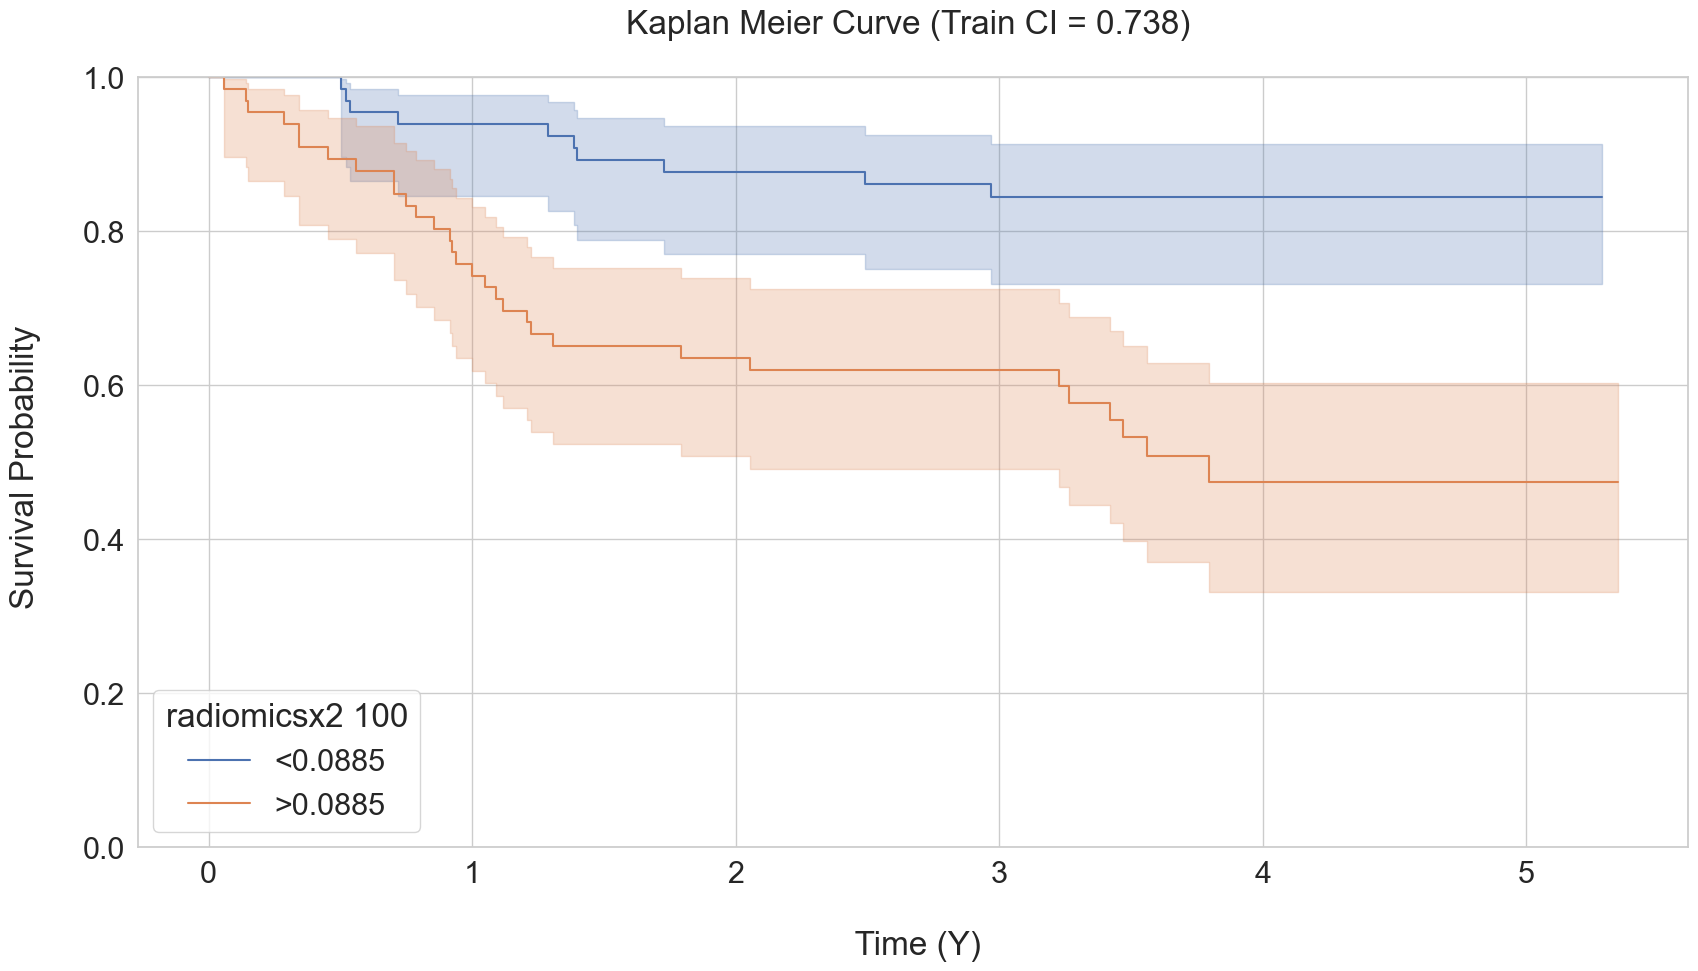

In [22]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low_r1_2['time'], event_observed=d_low_r1_2['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high_r1_2['time'], event_observed=d_high_r1_2['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(docrad_100_2['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx2 100')

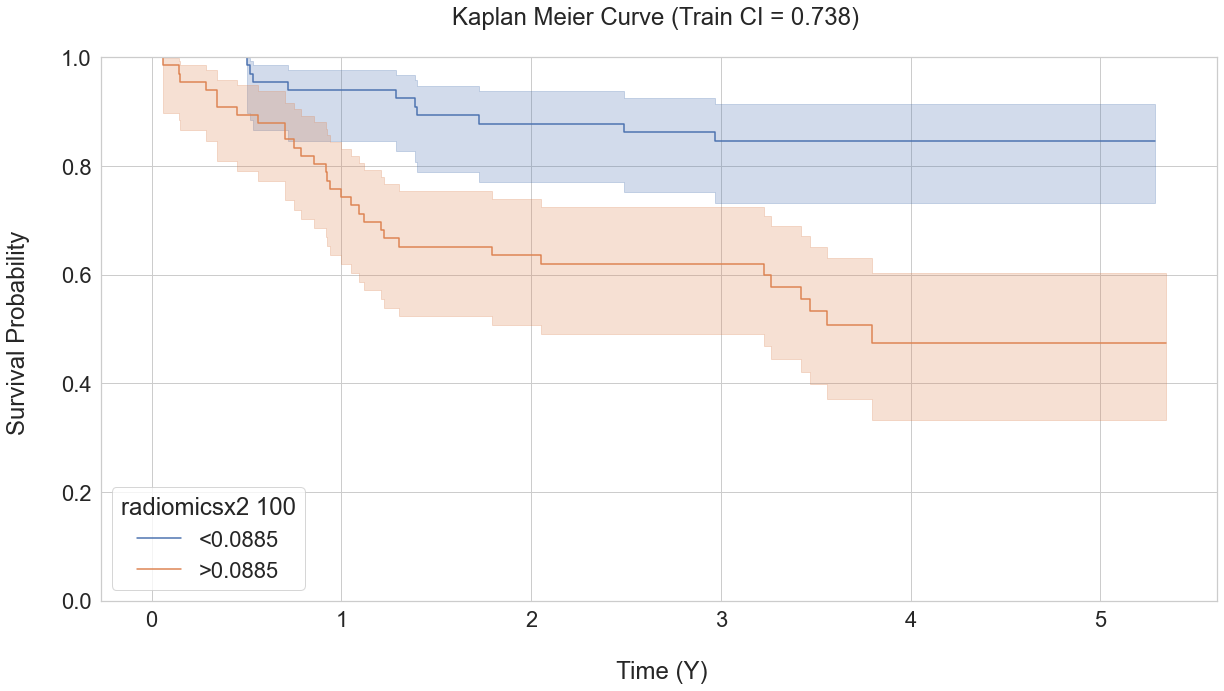

In [16]:
plt.figure(figsize=(20,10))
sea.set(font_scale=2) 
sea.set_style("whitegrid")
kmf.fit(d_low_r1_2['time'], event_observed=d_low_r1_2['event'], label=f'<{np.round(med,4)}')
kmf.plot()
kmf.fit(d_high_r1_2['time'], event_observed=d_high_r1_2['event'], label=f'>{np.round(med,4)}')
kmf.plot()
plt.title(f"Kaplan Meier Curve (Train CI = {np.round(docrad_100_2['train_ci'], 3)}) \n")
plt.ylabel('Survival Probability \n')
plt.ylim(0, 1.)
plt.xlabel('\n Time (Y)')
plt.legend(loc=3, title='radiomicsx2 100')

In [23]:
datarad1_2.to_csv('radiomics_100_signature_2_features_updated.csv')

In [45]:
########################################################
# extract the coefficients for the selected signature...
d_t = [pd.DataFrame(d).T for d in docrad_100_2["coefs"]]
covs_df = pd.concat(d_t)

In [47]:
covs_df.to_csv("coefficients_for_radiomics_mrme100_2_features.csv")

In [30]:
covs_df.iloc[0]

0.9607897295852683

In [42]:
list(docrad_100_2["coefs"][0].index)
list(docrad_100_2["coefs"][0])

[0.9607897295852683, 0.5872706123633337, 0.1436178688469043]

In [44]:
pd.DataFrame(docrad_100_2["coefs"][0]).T

covariate,cohort,log.sigma.4.5.mm.3D_glcm_Correlation,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity
coef,0.96079,0.587271,0.143618


In [1]:
# CREATE HEATMAP OF SIGNATURE
import seaborn as sns
import pandas as pd

In [11]:
data = pd.read_csv("coefficients_for_radiomics_mrme100_2_features.csv")

In [15]:
data.head()

,Unnamed: 0,cohort,log.sigma.4.5.mm.3D_glcm_Correlation,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity,wavelet.wavelet.LHH_ngtdm_Coarseness,log.sigma.4.5.mm.3D_ngtdm_Coarseness,log.sigma.2.0.mm.3D_firstorder_Minimum,log.sigma.2.5.mm.3D_firstorder_Minimum,wavelet.wavelet.LLH_glcm_Imc2,log.sigma.1.5.mm.3D_gldm_DependenceNonUniformity,...,wavelet.wavelet.HLH_glszm_GrayLevelNonUniformity,wavelet.wavelet.HLH_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLL_glszm_GrayLevelNonUniformity,wavelet.wavelet.LLH_glszm_GrayLevelNonUniformity,wavelet.wavelet.LLL_glcm_Idmn,log.sigma.0.5.mm.3D_glrlm_RunLengthNonUniformity,wavelet.wavelet.LLH_gldm_DependenceNonUniformity,wavelet.wavelet.HLL_glrlm_RunLengthNonUniformity,wavelet.wavelet.HHH_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet.wavelet.LHL_ngtdm_Strength
0,coef,0.960790,0.587271,0.143618,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,coef,0.574530,NaN,0.064915,-1.888743,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,coef,0.782124,NaN,NaN,NaN,-1.182567,-0.343641,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,coef,0.243759,NaN,NaN,NaN,NaN,NaN,-0.380939,-0.758434,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,coef,0.833952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data = data.drop(columns=["Unnamed: 0","cohort"])

In [40]:
features = list(data)

In [56]:
features = list(data)

f = {}
c = []
mean = []
for feat in features:
    c = len(data[feat]) -sum(data[feat].isna())
    f[feat] = {"counts":c, "mean_value":data[feat].mean()}

In [58]:
# data_ = {"features":feat, "counts":c, "mean_value":mean}
data_ = pd.DataFrame.from_dict(f)

In [116]:
d_ = data_.T.sort_values("counts", ascending=False)
d_freq = d_[d_["counts"]>1]
d_min = d_[d_["counts"]==1]

In [118]:
d_freq = pd.concat([d_freq, pd.DataFrame.from_dict({"other":{"counts":len(d_min), "mean_value":d_min["mean_value"].mean()}}).T])

In [124]:
d_freq.T

,log.sigma.2.0.mm.3D_glcm_JointAverage,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity,log.sigma.0.5.mm.3D_gldm_DependenceEntropy,log.sigma.2.0.mm.3D_firstorder_Minimum,wavelet.wavelet.LLH_ngtdm_Contrast,wavelet.wavelet.HLL_gldm_DependenceEntropy,wavelet.wavelet.LLH_glcm_Imc2,log.sigma.2.0.mm.3D_glszm_ZonePercentage,log.sigma.2.0.mm.3D_ngtdm_Contrast,log.sigma.4.5.mm.3D_firstorder_10Percentile,log.sigma.2.0.mm.3D_glcm_SumAverage,log.sigma.4.0.mm.3D_gldm_DependenceNonUniformityNormalized,glszm_SizeZoneNonUniformity,wavelet.wavelet.LLL_glcm_Correlation,other
counts,44.000000,16.000000,8.000000,7.000000,6.000000,6.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,93.000000
mean_value,0.394815,0.083825,0.261747,-0.370264,-0.780681,0.288349,-0.770576,-0.312221,-0.505101,-0.156556,0.449424,-0.549352,0.093464,0.655067,-0.142338


In [131]:
d_freq["feature"] = list(d_freq.index)

In [171]:
d_freq

,counts,mean_value,feature
log.sigma.2.0.mm.3D_glcm_JointAverage,44.0,0.394815,log.sigma.2.0.mm.3D_glcm_JointAverage
wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity,16.0,0.083825,wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity
log.sigma.0.5.mm.3D_gldm_DependenceEntropy,8.0,0.261747,log.sigma.0.5.mm.3D_gldm_DependenceEntropy
log.sigma.2.0.mm.3D_firstorder_Minimum,7.0,-0.370264,log.sigma.2.0.mm.3D_firstorder_Minimum
wavelet.wavelet.LLH_ngtdm_Contrast,6.0,-0.780681,wavelet.wavelet.LLH_ngtdm_Contrast
wavelet.wavelet.HLL_gldm_DependenceEntropy,6.0,0.288349,wavelet.wavelet.HLL_gldm_DependenceEntropy
wavelet.wavelet.LLH_glcm_Imc2,4.0,-0.770576,wavelet.wavelet.LLH_glcm_Imc2
log.sigma.2.0.mm.3D_glszm_ZonePercentage,4.0,-0.312221,log.sigma.2.0.mm.3D_glszm_ZonePercentage
log.sigma.2.0.mm.3D_ngtdm_Contrast,2.0,-0.505101,log.sigma.2.0.mm.3D_ngtdm_Contrast
log.sigma.4.5.mm.3D_firstorder_10Percentile,2.0,-0.156556,log.sigma.4.5.mm.3D_firstorder_10Percentile


<Axes: xlabel='counts', ylabel='mean_value'>

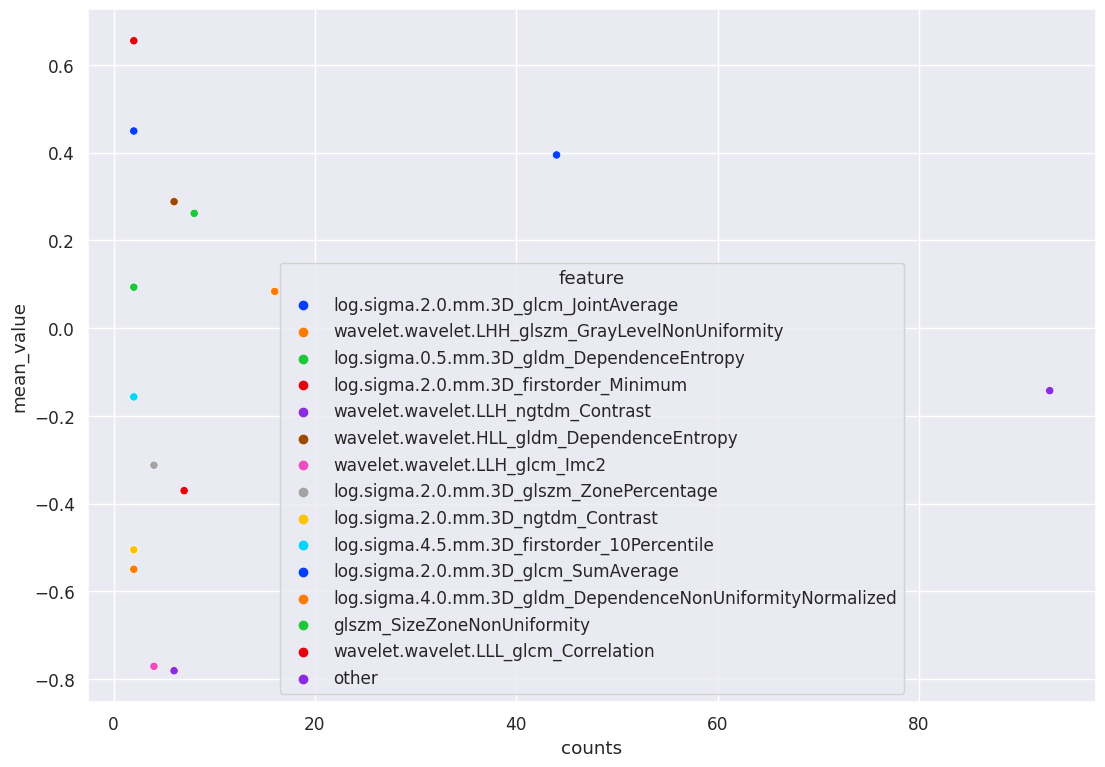

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,9))
sns.set(font_scale=1.1)
# sns.color_palette("tab10")
sns.scatterplot(d_freq, x="counts", y="mean_value", hue="feature", palette="bright")

<Axes: >

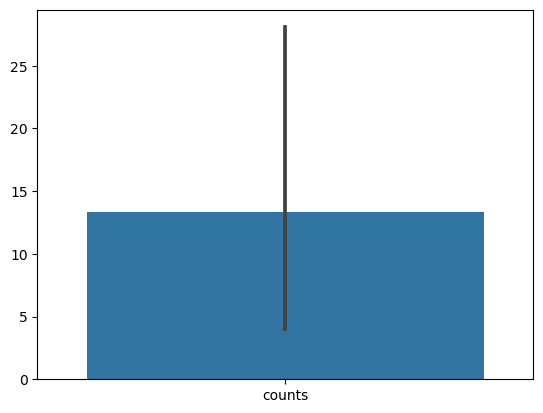

In [140]:
sns.histplot(data=d_freq.drop(columns=["mean_value"]), legend="feature")

In [97]:
data_.T[list(data_.T["counts"].argsort().index)]

KeyError: "None of [Index(['log.sigma.4.5.mm.3D_glcm_Correlation',\n       'wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity',\n       'wavelet.wavelet.LHH_ngtdm_Coarseness',\n       'log.sigma.4.5.mm.3D_ngtdm_Coarseness',\n       'log.sigma.2.0.mm.3D_firstorder_Minimum',\n       'log.sigma.2.5.mm.3D_firstorder_Minimum',\n       'wavelet.wavelet.LLH_glcm_Imc2',\n       'log.sigma.1.5.mm.3D_gldm_DependenceNonUniformity',\n       'log.sigma.2.0.mm.3D_glcm_JointAverage', 'log.sigma.5.0.mm.3D_glcm_Idn',\n       ...\n       'wavelet.wavelet.HLH_glszm_GrayLevelNonUniformity',\n       'wavelet.wavelet.HLH_glrlm_RunLengthNonUniformity',\n       'wavelet.wavelet.LLL_glszm_GrayLevelNonUniformity',\n       'wavelet.wavelet.LLH_glszm_GrayLevelNonUniformity',\n       'wavelet.wavelet.LLL_glcm_Idmn',\n       'log.sigma.0.5.mm.3D_glrlm_RunLengthNonUniformity',\n       'wavelet.wavelet.LLH_gldm_DependenceNonUniformity',\n       'wavelet.wavelet.HLL_glrlm_RunLengthNonUniformity',\n       'wavelet.wavelet.HHH_gldm_SmallDependenceLowGrayLevelEmphasis',\n       'wavelet.wavelet.LHL_ngtdm_Strength'],\n      dtype='object', length=107)] are in the [columns]"

In [93]:
list(data_.T["counts"].argsort().index)

['log.sigma.4.5.mm.3D_glcm_Correlation',
 'wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity',
 'wavelet.wavelet.LHH_ngtdm_Coarseness',
 'log.sigma.4.5.mm.3D_ngtdm_Coarseness',
 'log.sigma.2.0.mm.3D_firstorder_Minimum',
 'log.sigma.2.5.mm.3D_firstorder_Minimum',
 'wavelet.wavelet.LLH_glcm_Imc2',
 'log.sigma.1.5.mm.3D_gldm_DependenceNonUniformity',
 'log.sigma.2.0.mm.3D_glcm_JointAverage',
 'log.sigma.5.0.mm.3D_glcm_Idn',
 'log.sigma.2.0.mm.3D_glrlm_RunLengthNonUniformity',
 'log.sigma.4.0.mm.3D_glcm_Idn',
 'log.sigma.0.5.mm.3D_gldm_DependenceEntropy',
 'log.sigma.3.5.mm.3D_ngtdm_Coarseness',
 'log.sigma.2.5.mm.3D_gldm_DependenceNonUniformityNormalized',
 'log.sigma.4.5.mm.3D_glcm_Idmn',
 'log.sigma.3.0.mm.3D_gldm_SmallDependenceLowGrayLevelEmphasis',
 'wavelet.wavelet.LLL_ngtdm_Coarseness',
 'wavelet.wavelet.LLL_gldm_SmallDependenceLowGrayLevelEmphasis',
 'log.sigma.4.5.mm.3D_firstorder_10Percentile',
 'log.sigma.5.0.mm.3D_glcm_Idmn',
 'glcm_Idmn',
 'glszm_SizeZoneNonUniformity',
 'log.

In [69]:
sns.histplot(data_.T["counts"],binwidth=6)

ValueError: The following variable cannot be assigned with wide-form data: `hue`

In [44]:
data.mean()

log.sigma.4.5.mm.3D_glcm_Correlation                            0.587271
wavelet.wavelet.LHH_glszm_GrayLevelNonUniformity                0.083825
wavelet.wavelet.LHH_ngtdm_Coarseness                           -1.888743
log.sigma.4.5.mm.3D_ngtdm_Coarseness                           -1.182567
log.sigma.2.0.mm.3D_firstorder_Minimum                         -0.370264
                                                                  ...   
log.sigma.0.5.mm.3D_glrlm_RunLengthNonUniformity                0.131512
wavelet.wavelet.LLH_gldm_DependenceNonUniformity                0.131975
wavelet.wavelet.HLL_glrlm_RunLengthNonUniformity                0.144764
wavelet.wavelet.HHH_gldm_SmallDependenceLowGrayLevelEmphasis   -0.615715
wavelet.wavelet.LHL_ngtdm_Strength                             -0.519505
Length: 107, dtype: float64

<Axes: >

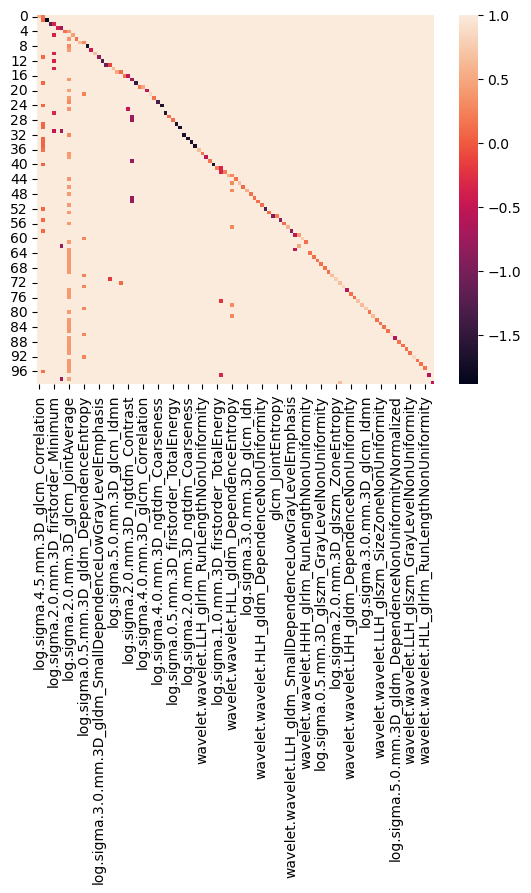

In [38]:
sns.heatmap(data.fillna(1))

In [22]:
counts = data.apply(pd.value_counts)

<Axes: >

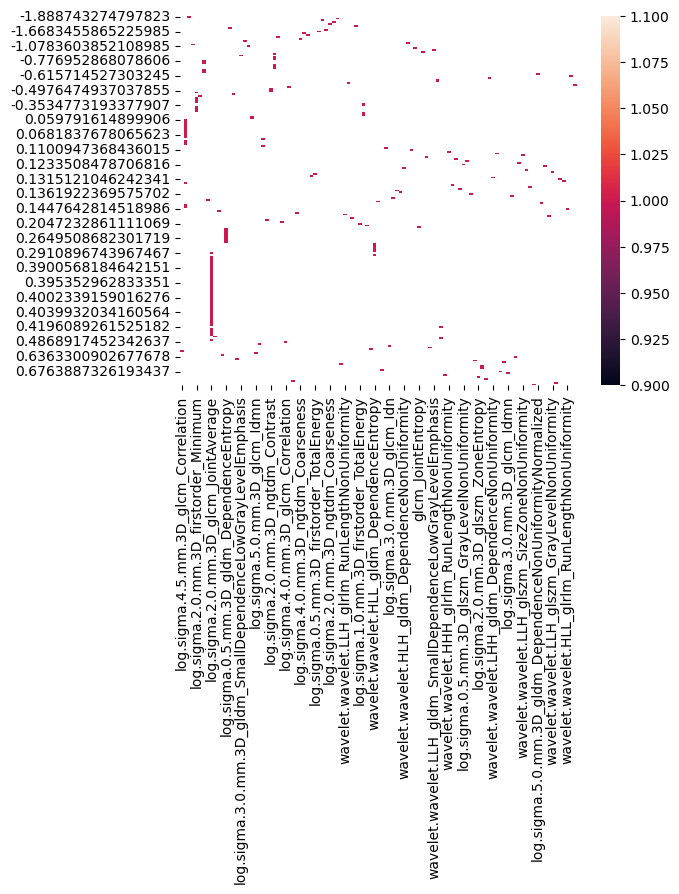

In [23]:
sns.heatmap(counts)

ValueError: could not broadcast input array from shape (100,107) into shape (100,)